In [225]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

sun_numax = 3090

In [226]:
def model():
    # Sample initial mass from Beta distribution and transform
    massini = numpyro.deterministic("massini", 
                                  0.8 * numpyro.sample("massini_s", dist.Beta(4, 4)) + 0.7)
    
    # Sample tau parameter from Beta distribution and transform
    tau_hat = numpyro.deterministic("tau_hat", 
                                   0.75 * numpyro.sample("tau_hat_s", dist.Beta(5, 5)) + 1) 
    
    fehini = numpyro.deterministic("fehini", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2.0)
    
    # Calculate intermediate tau value
    tau_ms = (10**9) * (massini**-3.7)
    
    # Calculate final age
    age = numpyro.deterministic("Age", tau_hat * tau_ms)
    
    return age



In [227]:
from jax import random

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:04<00:00, 1767.17it/s, 3 steps of size 7.92e-01. acc. prob=0.91]


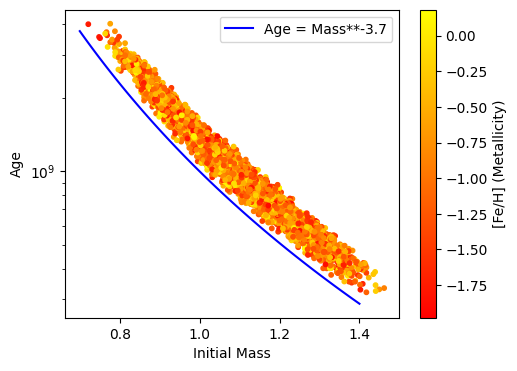

In [228]:
import arviz as az

trace = az.from_numpyro(mcmc)

ages_samples = trace.posterior['Age'].values.flatten()
mass_samples = trace.posterior['massini'].values.flatten()
fehini_samples = trace.posterior['fehini'].values.flatten()

x = np.linspace(0.7, 1.4, 100)
tau = (10**9) * (x**-3.7)

plt.figure(figsize=(5.4, 4))

# Scatter plot with fehini_samples mapped to color
sc = plt.scatter(mass_samples, ages_samples, c=fehini_samples, cmap='autumn', marker='o', s=10)

plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Initial Mass")
plt.ylabel("Age")

# Add a colorbar to show fehini values
cbar = plt.colorbar(sc)
cbar.set_label("[Fe/H] (Metallicity)")

plt.plot(x, tau, 'b', label='Age = Mass**-3.7')

plt.legend()
plt.show()
